In [1]:
import warnings
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 13, 7
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
import catboost
from catboost import Pool
from catboost import cv
#импортируем библиотеки

In [4]:
train_df = pd.read_csv('flight_delays_train.csv')
test_df = pd.read_csv('flight_delays_test.csv')
#считываем данные

In [5]:
test_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


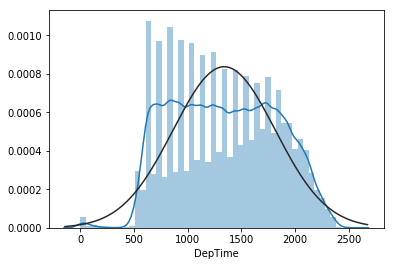

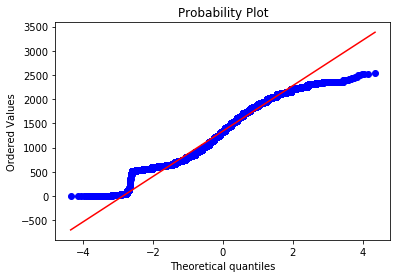

In [6]:
sns.distplot(train_df['DepTime'], fit=norm);
flg = plt.figure()
res = stats.probplot(train_df['DepTime'], plot=plt)

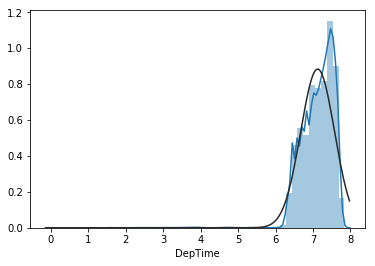

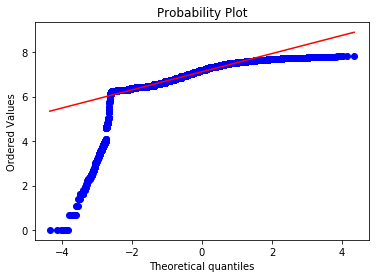

In [7]:
a = 0.001
sns.distplot(np.log(train_df['DepTime'] + a), fit=norm);
flg = plt.figure()
res = stats.probplot(np.log(train_df['DepTime'] + a), plot=plt)

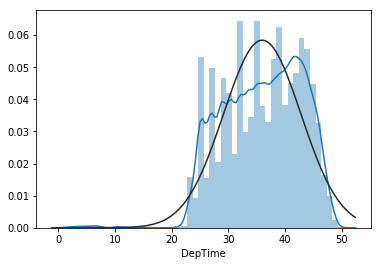

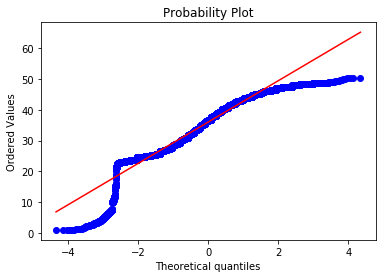

In [8]:
sns.distplot(np.sign(train_df['DepTime'])*(train_df['DepTime'].abs()**(1/2)), fit=norm);
flg = plt.figure()
res = stats.probplot(np.sign(train_df['DepTime'])*(train_df['DepTime'].abs()**(1/2)), plot=plt)

In [ ]:
sns.distplot(train_df['Distance'], fit=norm);
flg = plt.figure()
res = stats.probplot(train_df['Distance'], plot=plt)

In [10]:
bins = [-np.inf, 100, 500, 600,700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000, 2200, np.inf] 

In [11]:
train_df['dep_time_val'] = pd.cut(train_df['DepTime'], bins)
test_df['dep_time_val'] = pd.cut(test_df['DepTime'], bins)

In [12]:
biv = pd.crosstab(train_df['dep_time_val'], train_df['dep_delayed_15min'])
biv

dep_delayed_15min,N,Y
dep_time_val,,
"(-inf, 100.0]",145,169
"(100.0, 500.0]",84,65
"(500.0, 600.0]",1925,12
"(600.0, 700.0]",6205,162
"(700.0, 800.0]",5842,367
"(800.0, 900.0]",6093,513
"(900.0, 1000.0]",5631,738
"(1000.0, 1200.0]",10918,1797
"(1200.0, 1400.0]",10210,2291


In [13]:
woe = np.log(1.0*biv['N']/sum(biv['N']) + a) / (1.0*biv['Y']/sum(biv['Y']) + a)
woe

dep_time_val
(-inf, 100.0]       -595.625880
(100.0, 500.0]     -1403.982283
(500.0, 600.0]     -2268.413167
(600.0, 700.0]      -268.822028
(700.0, 800.0]      -129.004455
(800.0, 900.0]       -92.118304
(900.0, 1000.0]      -66.696520
(1000.0, 1200.0]     -20.932220
(1200.0, 1400.0]     -17.004405
(1400.0, 1600.0]     -15.529618
(1600.0, 1800.0]     -13.322863
(1800.0, 2000.0]     -12.827300
(2000.0, 2200.0]     -18.319417
(2200.0, inf]        -67.009090
dtype: float64

In [14]:
IV_cat = sum(((1.0*biv['N']/sum(biv['N']) + a) - (1.0*biv['Y']/sum(biv['Y']) 
                                              + a))*np.log((1.0*biv['N']/sum(biv['N']) + a) 
                                                           / (1.0*biv['Y']/sum(biv['Y']) + a)))
IV_cat

0.5460584977887866

In [ ]:
a = 0.001
sns.distplot(np.log(train_df['Distance'] + a), fit=norm);
flg = plt.figure()
res = stats.probplot(np.log(train_df['Distance'] + a), plot=plt)

In [ ]:
train_df['Distance'] = np.log(train_df['Distance'] + a)
test_df['Distance'] = np.log(test_df['Distance'] + a)
#делаем логарифмичсекое преобразование признака 'Distance'


In [ ]:
train_df.loc[train_df['flight'].value_counts()[train_df['flight']].values < 10, 'flight'] = 'other_flight'
test_df.loc[test_df['flight'].value_counts()[test_df['flight']].values < 10, 'flight'] = 'other_flight'
#признак 'flight' меньше 10 заменили на other

In [ ]:
train_df['unique_cnt'] = train_df['UniqueCarrier'].map(train_df['UniqueCarrier'].value_counts())
test_df['unique_cnt'] = test_df['UniqueCarrier'].map(test_df['UniqueCarrier'].value_counts())
#создаем признак с частотой признака 'UniqueCarrier'

In [ ]:
train_df['month_cnt'] = train_df['Month'].map(train_df['Month'].value_counts())
test_df['month_cnt'] = test_df['Month'].map(test_df['Month'].value_counts())
#создаем признак с частотой признака 'Month'

In [ ]:
train_df['day_month_cnt'] = train_df['DayofMonth'].map(train_df['DayofMonth'].value_counts())
test_df['day_month_cnt'] = test_df['DayofMonth'].map(test_df['DayofMonth'].value_counts())
#создаем признак с частотой признака 'DayofMonth'

In [ ]:
train_df['day_week_cnt'] = train_df['DayOfWeek'].map(train_df['DayOfWeek'].value_counts())
test_df['day_week_cnt'] = test_df['DayOfWeek'].map(test_df['DayOfWeek'].value_counts())
#создаем признак с частотой признака 'DayOfWeek'

In [ ]:
train_df.loc[train_df['Origin'].value_counts()[train_df['Origin']].values < 10, 'Origin'] = 'other_origin'
test_df.loc[test_df['Origin'].value_counts()[test_df['Origin']].values < 10, 'Origin'] = 'other_origin'
#признак 'Origin' меньше 10 заменили на other_origin

In [ ]:
train_df.loc[train_df['Dest'].value_counts()[train_df['Dest']].values < 10, 'Dest'] = 'other_Dest'
test_df.loc[test_df['Dest'].value_counts()[test_df['Dest']].values < 10, 'Dest'] = 'other_Dest'
#признак 'Dest' меньше 10 заменили на other_Dest

In [ ]:
train_df.head()

In [ ]:
test_df.head()

In [ ]:
train_df['day_dest'] = train_df['DayOfWeek'] + '---' + train_df['Dest']
test_df['day_dest'] = test_df['DayOfWeek'] + '---' + train_df['Dest']

In [ ]:
train_df['new_feature'] = train_df['Distance']/train_df['Dep_hour']
test_df['new_feature'] = test_df['Distance']/test_df['Dep_hour']

In [ ]:
train_df['day_uniq'] = train_df['DayOfWeek'] + '---' + train_df['UniqueCarrier']
test_df['day_uniq'] = test_df['DayOfWeek'] + '---' + train_df['UniqueCarrier']

In [ ]:
train_df['DepTime'].describe()

In [ ]:
train_df.columns

In [ ]:
features = list(set(train_df.columns))

In [ ]:
sns.pairplot(train_df, hue='dep_delayed_15min')

**Создайте только один признак - «flight» (это нужно улучшить - добавьте больше признаков)**

In [ ]:
train_df['Dep_hour'] =  train_df['DepTime']//100
train_df['Dep_hour'].replace(to_replace=[24,25], value=0, inplace=True)
test_df['Dep_hour'] =  test_df['DepTime']//100
test_df['Dep_hour'].replace(to_replace=[24,25], value=0, inplace=True)

In [ ]:
train_df['flight'] = train_df['Origin'] + '-->' + train_df['Dest']
test_df['flight'] = test_df['Origin'] + '-->' + test_df['Dest']

In [ ]:
train_df['Mon_un'] = train_df['Month'] + '-->' + train_df['UniqueCarrier']
test_df['Mon_un'] = test_df['Month'] + '-->' + test_df['UniqueCarrier']

In [ ]:
train_df['Mon_day'] = train_df['Month'] + '-->' + train_df['DayofMonth']
test_df['Mon_day'] = test_df['Month'] + '-->' + test_df['DayofMonth']

In [ ]:
train_df['Mon_or'] = train_df['Month'] + '-->' + train_df['Origin']
test_df['Mon_or'] = test_df['Month'] + '-->' + test_df['Origin']

In [ ]:
train_df['Mon_de'] = train_df['Month'] + '-->' + train_df['Dest']
test_df['Mon_de'] = test_df['Month'] + '-->' + test_df['Dest']

In [ ]:
train_df['Un_dest'] = train_df['UniqueCarrier'] + '-->' + train_df['Dest']
test_df['Un_dest'] = test_df['UniqueCarrier'] + '-->' + test_df['Dest']

In [ ]:
train_df['day_month'] = train_df['Month'] + '-->' + train_df['DayOfWeek']
test_df['day_month'] = test_df['Month'] + '-->' + test_df['DayOfWeek']

In [ ]:
train_df['Un_dest'] = train_df['UniqueCarrier'] + '-->' + train_df['Origin']
test_df['Un_dest'] = test_df['UniqueCarrier'] + '-->' + test_df['Origin']

In [ ]:
train_df['Dep_minute'] =  train_df['DepTime']%100
test_df['Dep_minute'] =  test_df['DepTime']%100

In [ ]:
train_df['fri_time'] = np.where((train_df['DayOfWeek'] == 'c-6') & (train_df['Dep_hour'] >20) \
                                | (train_df['Dep_hour'] <17), 1, 0)
test_df['fri_time'] = np.where((test_df['DayOfWeek'] == 'c-6') & (test_df['Dep_hour'] >20) \
                                | (test_df['Dep_hour'] <17), 1, 0)

In [ ]:
train_df['pic_time'] = np.where((train_df['Dep_hour'] >23) \
                                | (train_df['Dep_hour'] <6), 1, 0)
test_df['pic_time'] = np.where((test_df['Dep_hour'] >23) \
                                | (test_df['Dep_hour'] <6), 1, 0)

In [ ]:
train_df.columns

In [ ]:
def change_value_distance(x):
    if x < 200:
        return 'short'
    elif 200 <= x < 300:
        return 'medium1'
    elif 300 <= x < 420:
        return 'medium2'
    elif 420 <= x < 600:
        return 'medium3'
    elif 600 <= x < 800:
        return 'medium4'
    elif 800 <= x < 1000:
        return 'long1'
    elif 1000 <= x < 1500:
        return 'long2'
    elif x >= 1500:
        return 'long3'



In [ ]:
train_df['long_distance'] = train_df['Distance'].apply(lambda x: change_value_distance(x))
test_df['long_distance'] = train_df['Distance'].apply(lambda x: change_value_distance(x))

In [ ]:
train_df['long_distance'].value_counts()

In [ ]:
sns.countplot(x='long_distance', hue='dep_delayed_15min', data=train_df);

In [ ]:
def change_value_dephour(x):
    if 6 > x >= 0:
        return 'night'
    elif 12 > x >= 6:
        return 'morning'
     elif 18 > x >= 12:
        return 'day'
    else:
        return 'evening'

In [ ]:
train_df['time_day'] = train_df['Dep_hour'].apply(lambda x: change_value_dephour(x))
test_df['time_day'] = train_df['Dep_hour'].apply(lambda x: change_value_dephour(x))

In [ ]:
sns.countplot(x='time_day', hue='dep_delayed_15min', data=train_df);

In [ ]:
train_df.info()

In [ ]:
train_df = train_df.astype(object) 
test_df = test_df.astype(object) 

In [ ]:
train_df_yes = train_df[train_df['dep_delayed_15min'] == 'Y']


In [ ]:
train_df_no = train_df[train_df['dep_delayed_15min'] == 'N']


**Запомните индексы категориальных функций (для передачи в CatBoost)**

In [ ]:
categ_feat_idx = np.where(train_df.drop('dep_delayed_15min', axis=1).dtypes == 'object')[0]
categ_feat_idx

In [ ]:
indexes = np.where(train_df.drop('dep_delayed_15min', axis=1).dtypes == 'int64')[0]
indexes

In [ ]:
train_df.head()

In [ ]:
my_features = np.array([0, 1, 2, 4,  5 , 8,  9, 10])

In [ ]:
ignored_features = np.array([0, 1, 2, 20])

**Выделите hold out set (validation set) для проверки модели**

In [ ]:
X_train = train_df.drop('dep_delayed_15min', axis=1).values
y_train = train_df['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test_df.values

In [ ]:
params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'depth':7,
          'cat_features': categ_feat_idx,
         
          'early_stopping_rounds': 100,
          'learning_rate':0.1,
          'verbose': 500,
          'random_seed': 17
         }

In [ ]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, 
                                                                test_size=0.25, 
                                                                random_state=17)

In [ ]:
grid = {
 
    
    
    'learning_rate': [0.07, 0.1],
    'depth': [3, 4, 5, 6, 7, 8],
    'l2_leaf_reg': [1, 3, 5, 7, 9, 20, 30]
}

In [ ]:
params_tune = {'depth':[3,1,2,6,4,5,7,8,9,10],
          'iterations':[250,100,500,1000],
          'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
          'l2_leaf_reg':[3,1,5,10,100],
          'border_count':[32,5,10,20,50,100,200],
          
          }

In [ ]:
model = CatBoostClassifier(**params)

In [ ]:

grid_search_result = model.grid_search(grid, X_train_part, y_train_part, shuffle=False, cv=3, partition_random_seed=17)

In [ ]:
print(grid_search_result)

In [ ]:
scores = []

In [ ]:
score = model.get_best_score()['validation_0']['AUC']
scores.append(score)

**Train Catboost с аргументами по умолчанию, передавая только индексы категориальных функций..**

In [ ]:
ctb = CatBoostClassifier(**params)

In [ ]:
%%time
ctb.fit(X_train_part, y_train_part,
        eval_set=(X_valid, y_valid),
          use_best_model=True,
          plot=True
         );


In [ ]:
train_data = Pool(data=X_train_part,
                  label=y_train_part,
                  cat_features=categ_feat_idx
                 )

valid_data = Pool(data=X_valid,
                  label=y_valid,
                  cat_features=categ_feat_idx
                 )

In [ ]:
%%time



all_train_data = Pool(data=X_train,
                      label=y_train,
                      cat_features=categ_feat_idx
                     )

scores = cv(pool=all_train_data,
            params=params, 
            fold_count=4,
            seed=17, 
            shuffle=True,
            stratified=True, # if True the folds are made by preserving the percentage of samples for each class
            plot=True
           )

In [ ]:
train_df.groupby(['dep_delayed_15min'])['DayOfWeek'].value_counts()

In [ ]:
train_df.groupby(['dep_delayed_15min'])['Dep_hour'].value_counts()

In [ ]:
train_df.head()

In [ ]:
ctb.get_feature_importance(prettified=True)

In [ ]:
ctb_valid_pred = ctb.predict_proba(X_valid)[:, 1]

**We got some 0.756 ROC AUC on the hold-out set.**

In [ ]:
roc_auc_score(y_valid, ctb_valid_pred)

**Train on the whole train set, make prediction on the test set. We got ~0.734 in the competition - "Catboost starter" baseline**

In [ ]:
%%time
ctb.fit(X_train, y_train,
        cat_features=categ_feat_idx);

In [ ]:
ctb_test_pred = ctb.predict_proba(X_test)[:, 1]


In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    sample_sub = pd.read_csv('sample_submission.csv', 
                             index_col='id')
    sample_sub['dep_delayed_15min'] = ctb_test_pred
    sample_sub.to_csv('ctb_pred.csv')

In [ ]:
!head ctb_pred.csv

Now's your turn! Go and improve the model to beat **"A2 baseline (10 credits)"** - **0.75914** LB score. It's crucial to come up with some good features. 

For discussions, stick to the **#a2_kaggle_fall2019** thread in the **mlcourse_ai_news** [ODS Slack](http://opendatascience.slack.com) channel. Serhii Romanenko (@serhii_romanenko) will be there to help. 

Welcome to Kaggle!

<img src='https://habrastorage.org/webt/fs/42/ms/fs42ms0r7qsoj-da4x7yfntwrbq.jpeg' width=50%>
*from the ["Nerd Laughing Loud"](https://www.kaggle.com/general/76963) thread.*